# iSentia ML Challange

## Packages

In [26]:
import gzip
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
from tqdm import trange
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import ssl
import certifi
ssl._create_default_https_context = ssl._create_unverified_context
ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=certifi.where())
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt')
nltk.download('stopwords')
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import download

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohsinkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohsinkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load Datasets

In [2]:
def load_data_from_gzip(gzip_file_path):
    """Reads content from a gzip file and returns it as a Pandas DataFrame."""
    with gzip.open(gzip_file_path, 'rt', encoding='utf-8') as file:
        data = pd.DataFrame(file.readlines(), columns=['article'])
    return data

# Load the data from both the test and train gzip files
train_data = load_data_from_gzip('train.txt.gzip')
test_data = load_data_from_gzip('test.txt.gzip')

print(f"Number of articles in the train dataset: {train_data.shape[0]}\nNumber of articles in the test dataset: {test_data.shape[0]}")

Number of articles in the train dataset: 232882
Number of articles in the test dataset: 58221


## Explore the Data

Lets explore a few news articles from the train & test text file to realise the data structure

In [3]:
for i, article in enumerate(train_data['article'].head(3), start=1):
    print(f"Article {i}:\n{article[:]}\n{'-'*100}\n")

Article 1:
 New investment will accelerate Divergent’s efforts to globally commercialize its additive manufacturing-enabled technology LOS ANGELES & HONG KONG(BUSINESS WIRE) Divergent 3D, a technology development and licensing company that is creating a sustainable manufacturing revolution in the car industry, announces a Series B financing scheduled for close on or before December 15, 2017. The Series B close is $65+million with an additional investor option of $40 million to further accelerate revenue growth, bringing the aggregate funding, with option, to $107 million. Hong Kong-based investment holding company, O Luxe Holdings Limited ("O Luxe"), led the investment group, which includes Horizons Ventures, Shanghai Alliance Investment Limited and Altran Technologies. Launched in 2014 by Founder & CEO Kevin Czinger, Divergent’s patented, end-to-end software-hardware solution incorporates 3D metal printing into the design, engineering and manufacturing of advanced vehicle structures f

<b>Note: Upon exploring the news articles, its apparent that the articles and labels are part of the same corpus, 
lets extract these labels from the articles<b>

In [5]:
def extract_labels(data):
    data['label'] = data['article'].apply(lambda x: re.search(r'__label__(\S+)', x).group(1).replace("&", ",") if re.search(r'__label__(\S+)', x) else None)   
    data['article'] = data['article'].apply(lambda x: re.sub(r'__label__\S+', '', x).strip())
    return data

train_data_labeled = extract_labels(train_data)
test_data_labeled = extract_labels(test_data)

In [6]:
print('Training Data:')
train_data_labeled.head(10)

Training Data:


,article,label
0,New investment will accelerate Divergent’s eff...,"Energy,Resources,Utilities"
1,INTERPOL is now hunting for fugitive ex-Queens...,"Legal,Defence"
2,"21 Things on in Victoria, let us do the drivin...",Entertainment
3,We should give thanks for small mercies. At le...,"Food,Beverage"
4,"""From The Heart of Australia, For the Future o...","Information,Technology,Telecommunications"
5,A KEY One Nation figure who served as an advis...,"Energy,Resources,Utilities"
6,Another project in the region needs urgent att...,"Energy,Resources,Utilities"
7,Following on from the highs and lows of the pr...,Entertainment
8,Australian Prescriber is an independent peer-r...,Pharmaceutical
9,"A story about me and Jacqui at Hervey Bay, wit...","Information,Technology,Telecommunications"


In [7]:
print('Testing Data:')
test_data_labeled.head(10)

Testing Data:


,article,label
0,"Traversing a land of high peaks, glaciers and ...","Transport,Storage"
1,Development giant Lendlease has stepped up its...,RetailTrade
2,SADLY for Territorians we have a Band-Aid gove...,"Energy,Resources,Utilities"
3,The ACTU has called for the Coalition's workpl...,"Energy,Resources,Utilities"
4,ROSEDALE'S Sophie Crooke has pipped eight othe...,"Agriculture,Forestry,Fishing"
5,Media Release - 28/08/17 The Conservation Coun...,Environment
6,I SEE that Gordon Gekko is alive and well in C...,"Transport,Storage"
7,facebook.com/goldcoastbulletin City leaders ar...,"Transport,Storage"
8,THE Australian market looks set to follow Wall...,"Transport,Storage"
9,It looks like Tony Fung’s Casino Canberra will...,"Sport,Gaming"


### Lets start with characters & words withing the corpus:

Lets start by checking how long the articles are
- Count of Characters per Article: This helps understand the length distribution of the articles, which can be important for identifying outliers or understanding the dataset's depth.
- Word Count per Article: Similar to character count, this metric provides insights into the articles' verbosity, which can influence the choice of preprocessing and modeling techniques.
- Mean Word Length: Offers a glimpse into the complexity and lexical diversity within the articles.
- Mean Sentence Length: Can indicate the writing style and complexity of the content across different articles.

#### Count of Characters per Article:

In [11]:
train_data['char_count'] = train_data['article'].swifter.apply(len)
train_data['word_count'] = train_data['article'].swifter.apply(lambda x: len(word_tokenize(x)))
train_data['mean_word_length'] = train_data['article'].swifter.apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]) if word_tokenize(x) else 0)
train_data['mean_sentence_length'] = train_data['article'].swifter.apply(lambda x: np.mean([len(sent) for sent in sent_tokenize(x)]) if sent_tokenize(x) else 0)

Pandas Apply: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232882/232882 [01:42<00:00, 2266.63it/s]


In [13]:
train_data.head(10)

,article,label,char_count,word_count,mean_word_length,mean_sentence_length
0,New investment will accelerate Divergent’s eff...,"Energy,Resources,Utilities",5664,912,5.368421,187.833333
1,INTERPOL is now hunting for fugitive ex-Queens...,"Legal,Defence",2703,506,4.458498,134.200000
2,"21 Things on in Victoria, let us do the drivin...",Entertainment,6752,1332,4.299550,62.112150
3,We should give thanks for small mercies. At le...,"Food,Beverage",5968,1107,4.569106,126.000000
4,"""From The Heart of Australia, For the Future o...","Information,Technology,Telecommunications",2989,503,5.037773,198.333333
5,A KEY One Nation figure who served as an advis...,"Energy,Resources,Utilities",1550,291,4.439863,118.307692
6,Another project in the region needs urgent att...,"Energy,Resources,Utilities",3641,629,4.920509,120.400000
7,Following on from the highs and lows of the pr...,Entertainment,5192,1121,3.807315,87.016949
8,Australian Prescriber is an independent peer-r...,Pharmaceutical,438,61,6.278689,145.333333
9,"A story about me and Jacqui at Hervey Bay, wit...","Information,Technology,Telecommunications",5911,1259,3.828435,130.377778


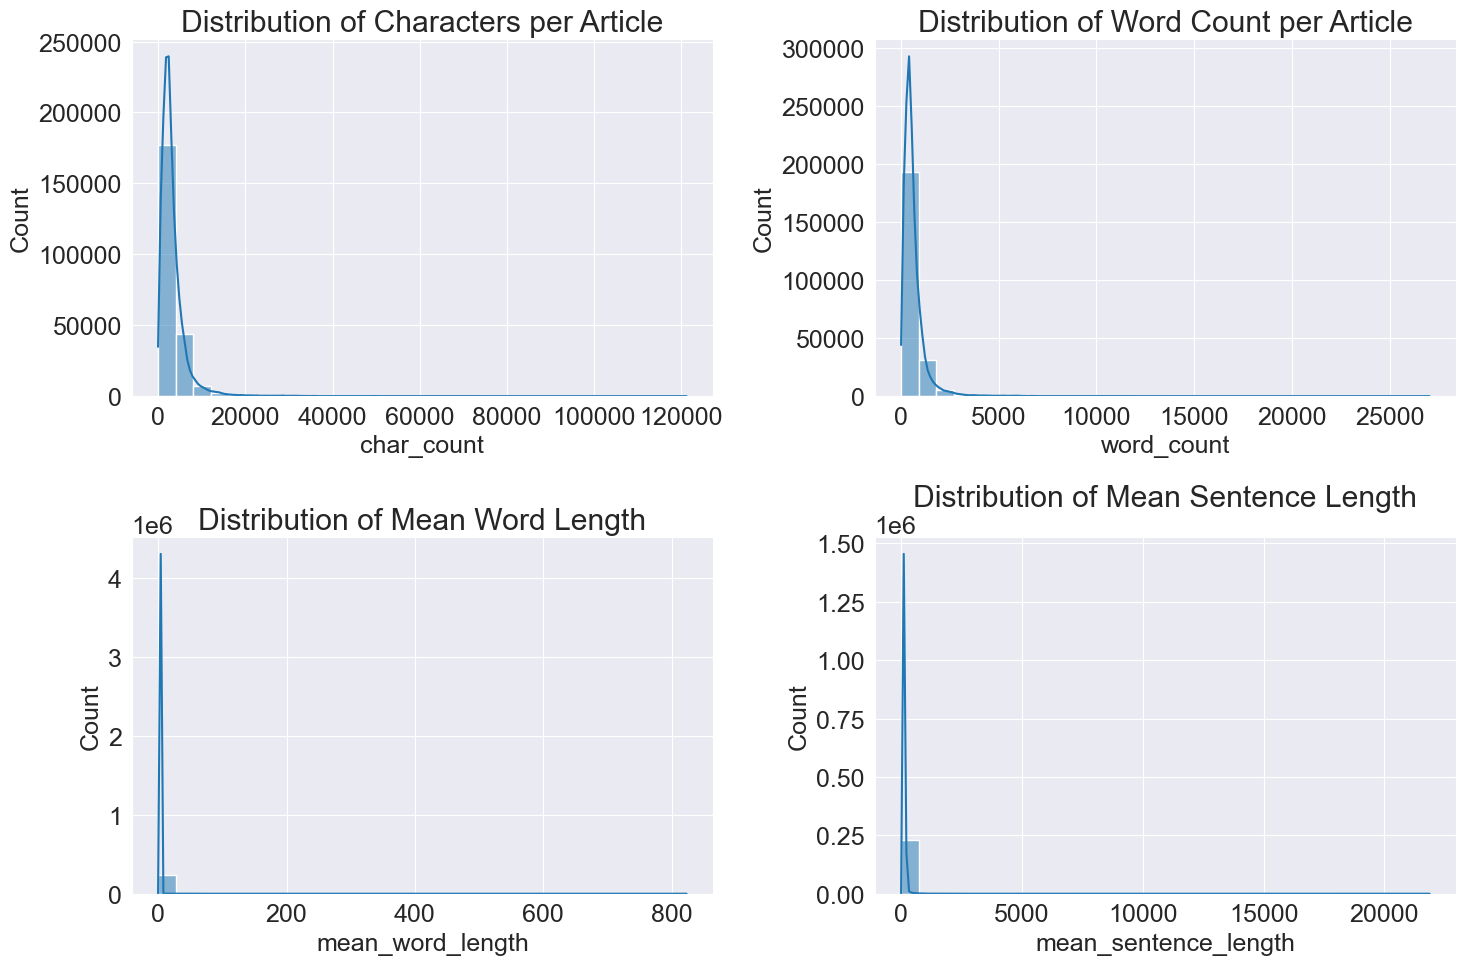

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(train_data['char_count'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Characters per Article')

sns.histplot(train_data['word_count'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Word Count per Article')

sns.histplot(train_data['mean_word_length'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Mean Word Length')

sns.histplot(train_data['mean_sentence_length'], bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Mean Sentence Length')

plt.tight_layout()
plt.show()

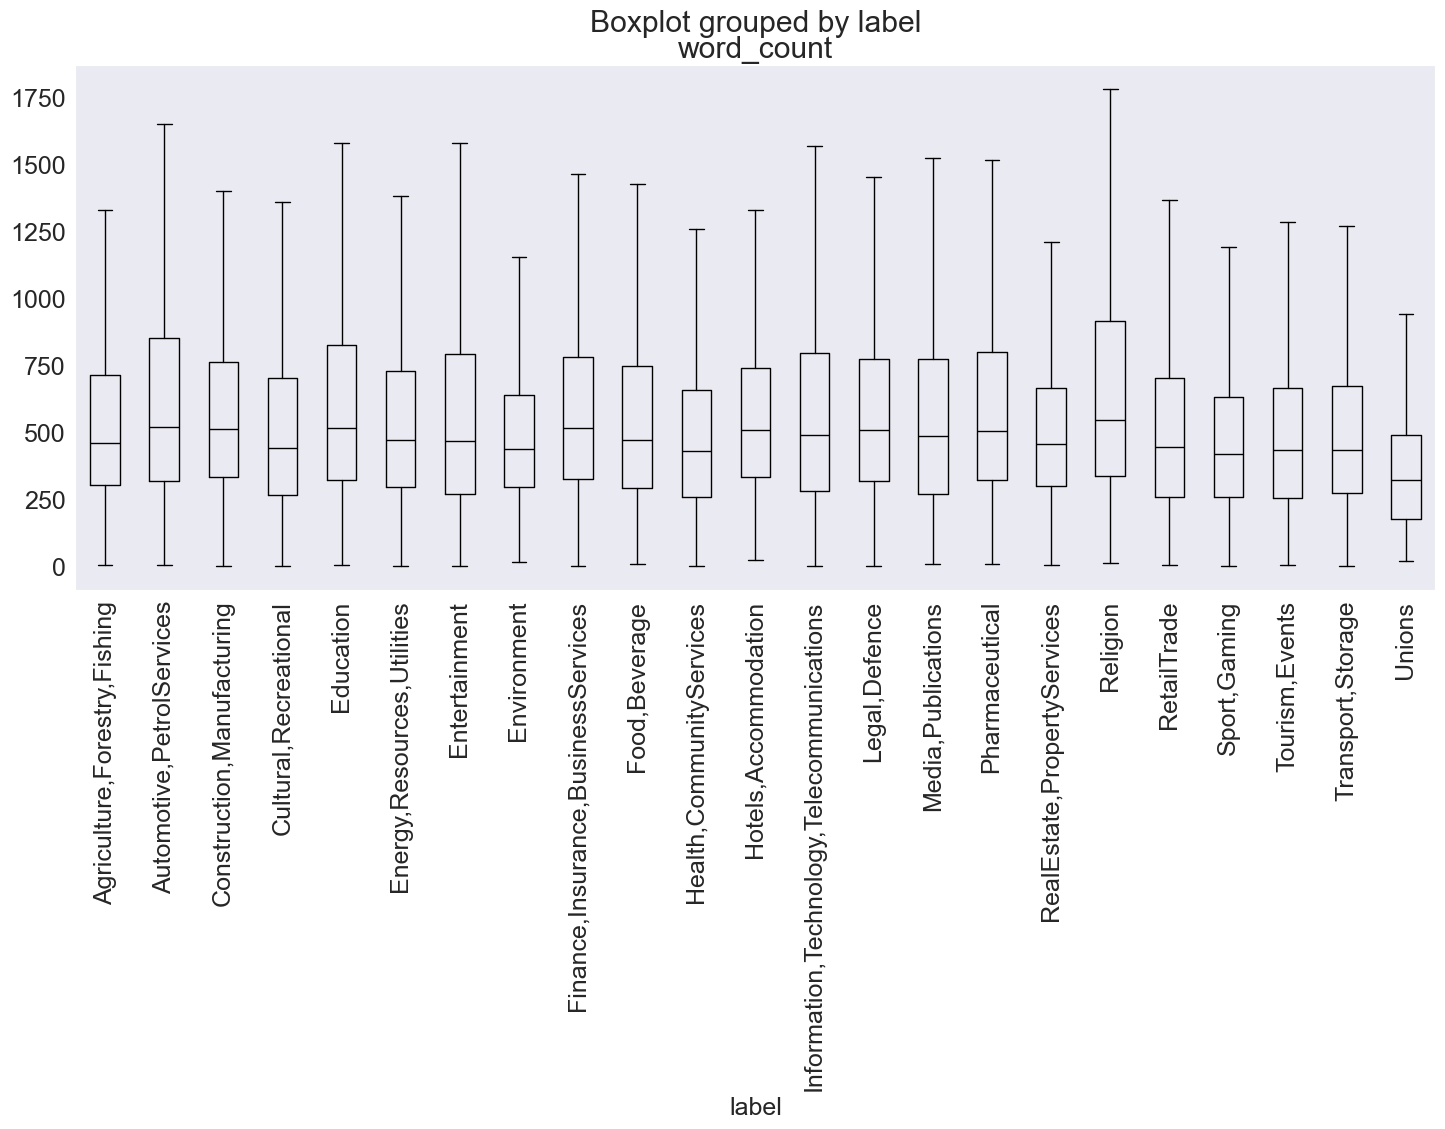

In [14]:
train_data.boxplot("word_count", by='label', grid=False, showfliers=False,
           color='black', )
plt.xticks(rotation = 90)
plt.show()

### Most frequent words

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(train_data['article'])
freqs = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0])
word_freq = sorted(freqs, key=lambda x: -x[1])

word_freq_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])
print(word_freq_df.head(20))

          word  frequency
0         said     654166
1         year     323004
2          new     287018
3    australia     252325
4         cent     219367
5       people     208424
6           mr     206514
7   government     189818
8         time     186796
9   australian     185099
10       years     171996
11        just     153219
12     million     151134
13      market     147212
14        says     136385
15        like     134685
16     company     123342
17    business     119795
18         day     112137
19         000     109837


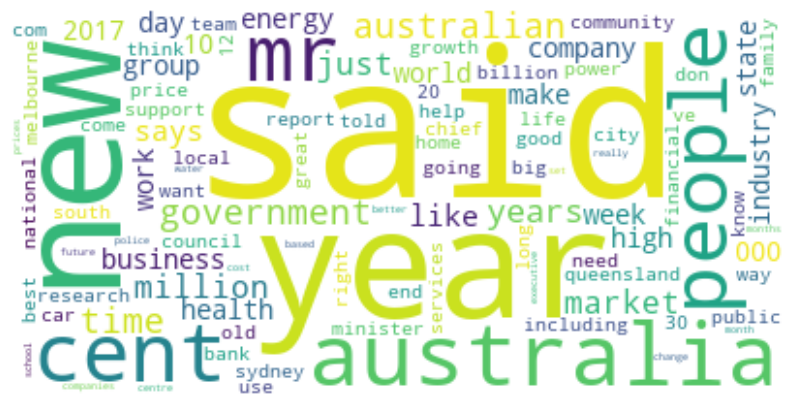

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(word_freq))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Article Sentiments

In [20]:
from textblob import TextBlob
train_data['sentiment'] = train_data['article'].swifter.apply(lambda x: TextBlob(x).sentiment.polarity)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232882/232882 [04:44<00:00, 819.50it/s]


In [21]:
train_data.head(10)

,article,label,char_count,word_count,mean_word_length,mean_sentence_length,sentiment
0,New investment will accelerate Divergent’s eff...,"Energy,Resources,Utilities",5664,912,5.368421,187.833333,0.130813
1,INTERPOL is now hunting for fugitive ex-Queens...,"Legal,Defence",2703,506,4.458498,134.200000,0.047984
2,"21 Things on in Victoria, let us do the drivin...",Entertainment,6752,1332,4.299550,62.112150,0.133794
3,We should give thanks for small mercies. At le...,"Food,Beverage",5968,1107,4.569106,126.000000,0.165545
4,"""From The Heart of Australia, For the Future o...","Information,Technology,Telecommunications",2989,503,5.037773,198.333333,0.043021
5,A KEY One Nation figure who served as an advis...,"Energy,Resources,Utilities",1550,291,4.439863,118.307692,-0.022500
6,Another project in the region needs urgent att...,"Energy,Resources,Utilities",3641,629,4.920509,120.400000,0.119528
7,Following on from the highs and lows of the pr...,Entertainment,5192,1121,3.807315,87.016949,0.137953
8,Australian Prescriber is an independent peer-r...,Pharmaceutical,438,61,6.278689,145.333333,0.050000
9,"A story about me and Jacqui at Hervey Bay, wit...","Information,Technology,Telecommunications",5911,1259,3.828435,130.377778,0.172316


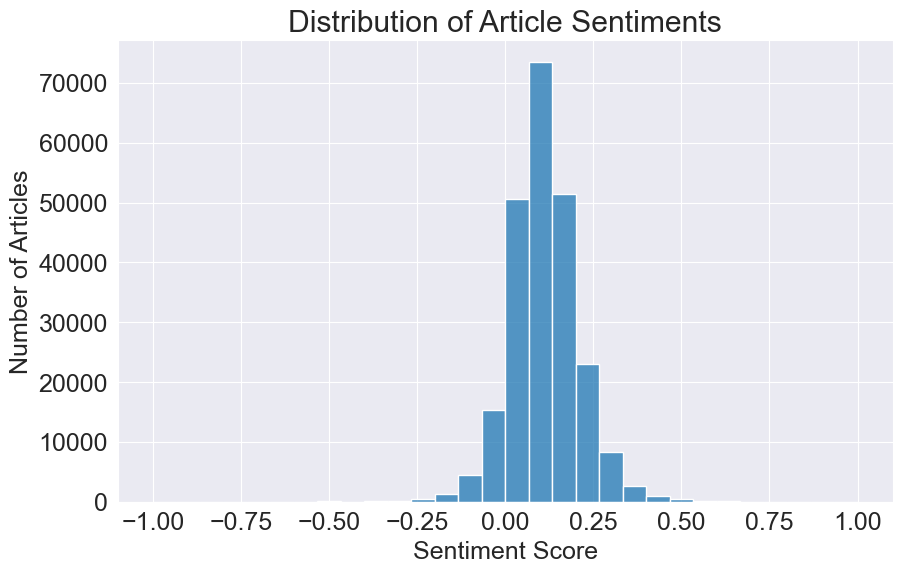

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['sentiment'], bins=30, kde=False)
plt.title('Distribution of Article Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Articles')
plt.show()

Looking at the sentiment histogram, we can gather several insights:

- Central Tendency: Most articles seem to have a neutral sentiment, as indicated by the tall, central bars around the 0 mark. This is common in news articles and general information text, which often aim for an unbiased presentation.

- Skewness: The distribution appears to be slightly skewed towards positive sentiment, given the slightly longer tail on the right side of the histogram. This suggests a subset of the articles might have a more positive tone.

- Sentiment Extremes: There are relatively few articles with extreme sentiments, either positive or negative. Extreme sentiments could indicate opinion pieces, emotionally charged reports, or specific topics that tend to evoke stronger sentiments.

In terms of next steps, we can use sentiment analysis as:
- Sentiment as a Feature: The sentiment scores can be used as a feature for clustering to see if there is any natural grouping based on sentiment, which could help uncover latent structures within the data related to article tone.

- Content Context: It would be beneficial to examine the content of articles with high positive and negative sentiments to ensure that the sentiment analysis is aligned with the perceived sentiment. This could also help us understand the context in which certain sentiments are expressed.

### Unique Words

In [22]:
train_data['unique_words'] = train_data['article'].swifter.apply(lambda x: len(set(word_tokenize(x))))
train_data.head(10)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232882/232882 [06:07<00:00, 633.18it/s]


,article,label,char_count,word_count,mean_word_length,mean_sentence_length,sentiment,unique_words
0,New investment will accelerate Divergent’s eff...,"Energy,Resources,Utilities",5664,912,5.368421,187.833333,0.130813,411
1,INTERPOL is now hunting for fugitive ex-Queens...,"Legal,Defence",2703,506,4.458498,134.200000,0.047984,247
2,"21 Things on in Victoria, let us do the drivin...",Entertainment,6752,1332,4.299550,62.112150,0.133794,732
3,We should give thanks for small mercies. At le...,"Food,Beverage",5968,1107,4.569106,126.000000,0.165545,523
4,"""From The Heart of Australia, For the Future o...","Information,Technology,Telecommunications",2989,503,5.037773,198.333333,0.043021,281
5,A KEY One Nation figure who served as an advis...,"Energy,Resources,Utilities",1550,291,4.439863,118.307692,-0.022500,167
6,Another project in the region needs urgent att...,"Energy,Resources,Utilities",3641,629,4.920509,120.400000,0.119528,314
7,Following on from the highs and lows of the pr...,Entertainment,5192,1121,3.807315,87.016949,0.137953,493
8,Australian Prescriber is an independent peer-r...,Pharmaceutical,438,61,6.278689,145.333333,0.050000,45
9,"A story about me and Jacqui at Hervey Bay, wit...","Information,Technology,Telecommunications",5911,1259,3.828435,130.377778,0.172316,528


## Data Pre-processing & Cleaning

In [37]:
train_df = train_data[['article', 'sentiment']]

In [38]:
class TextPreprocessor:
    def __init__(self, use_stopwords=True, use_lemmatization=True, remove_numbers=True, ngram_range=(1,1)):
        self.use_stopwords = use_stopwords
        self.use_lemmatization = use_lemmatization
        self.remove_numbers = remove_numbers
        self.ngram_range = ngram_range
        if use_stopwords:
            self.stopwords = set(stopwords.words('english'))
        if use_lemmatization:
            self.lemmatizer = WordNetLemmatizer()
        self.tfidf_vectorizer = None

    def preprocess(self, df, text_column='article'):
        df[text_column] = df[text_column].astype(str)
        df['clean_article'] = df[text_column].swifter.apply(self.clean_article)
        df['tokens'] = df['clean_article'].swifter.apply(word_tokenize)
        return df

    def clean_article(self, article):
        if not isinstance(article, str):
            return ""
        if self.remove_numbers:
            article = re.sub(r'\d+', '', article)
        article = re.sub(r'[^a-z\s]', '', article.lower())
        tokens = word_tokenize(article)
        if self.use_stopwords:
            tokens = [word for word in tokens if word not in self.stopwords and len(word) >= 3]
        if self.use_lemmatization:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return " ".join(tokens)

    def vectorize_text(self, texts):
        if not self.tfidf_vectorizer:
            self.tfidf_vectorizer = TfidfVectorizer(ngram_range=self.ngram_range, stop_words='english')
            self.tfidf_vectorizer.fit(texts)
        return self.tfidf_vectorizer.transform(texts)

In [39]:
preprocessor = TextPreprocessor(ngram_range=(1, 2)) 

In [41]:
# Preprocess the training data
train_df_processed = preprocessor.preprocess(train_df, text_column='article')

# Vectorize the training data
texts = train_df_processed['clean_article']
tfidf_matrix = preprocessor.vectorize_text(texts)

Pandas Apply: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232882/232882 [02:16<00:00, 1704.60it/s]


In [44]:
# Recalculate the statistics on the cleaned data
train_df_processed['word_count'] = train_df_processed['clean_article'].apply(lambda x: len(x.split()))
train_df_processed['sentence_count'] = train_df_processed['clean_article'].apply(lambda x: len(sent_tokenize(x)))
train_df_processed['avg_word_length'] = train_df_processed['clean_article'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
train_df_processed['avg_sentence_length'] = train_df_processed['clean_article'].apply(lambda x: np.mean([len(sent) for sent in sent_tokenize(x)]) if sent_tokenize(x) else 0)

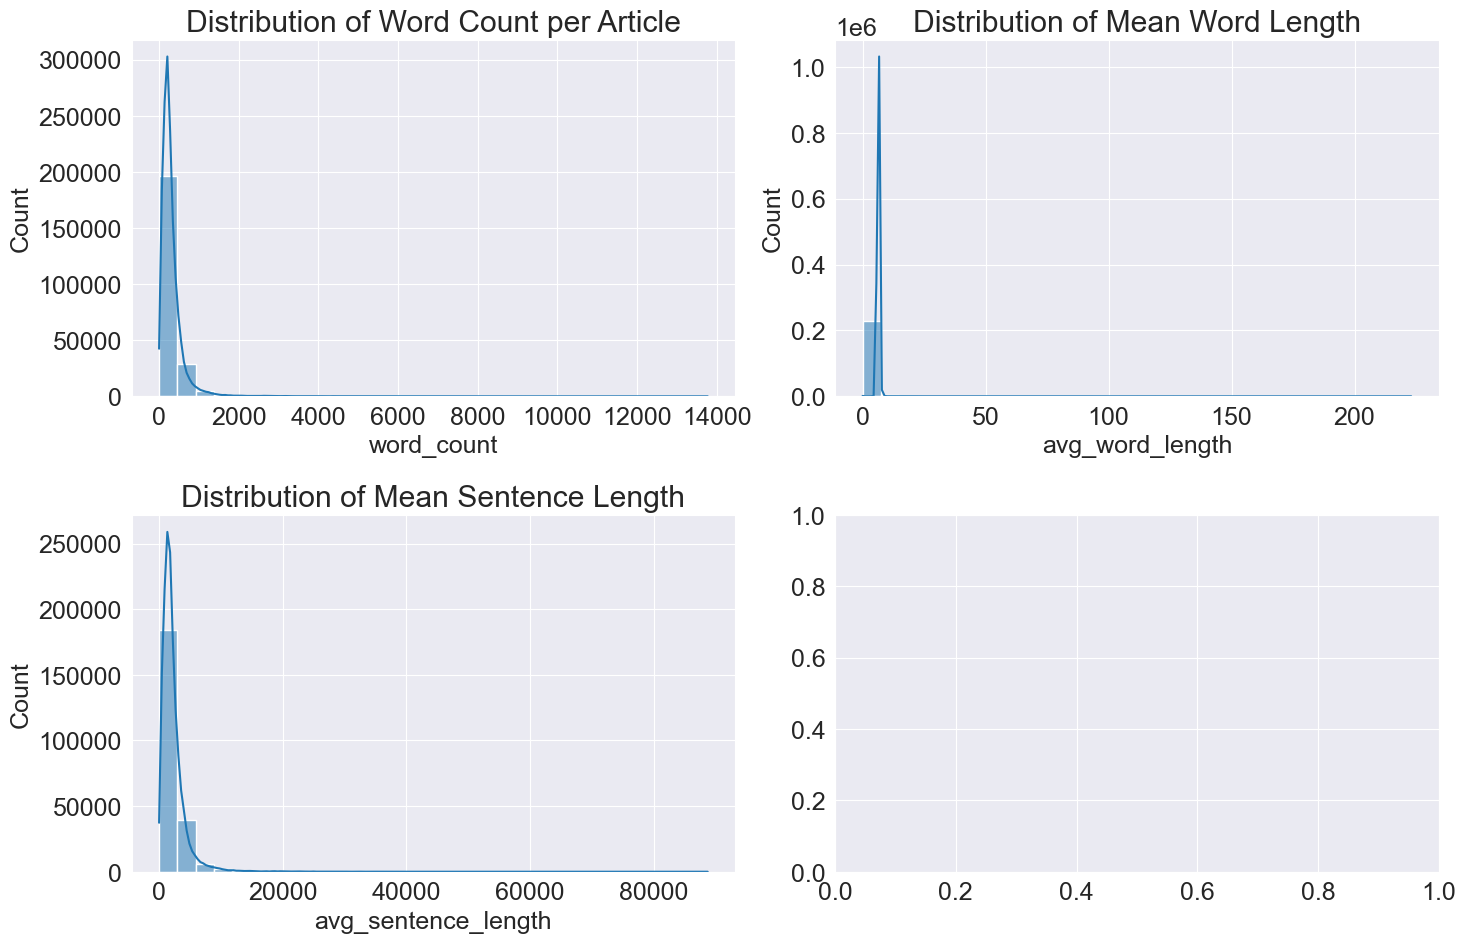

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(train_df_processed['word_count'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Word Count per Article')

sns.histplot(train_df_processed['avg_word_length'] , bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Mean Word Length')

sns.histplot(train_df_processed['avg_sentence_length'], bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Mean Sentence Length')

plt.tight_layout()
plt.show()

In [52]:
train_df_processed['sentiment'] = train_df_processed['clean_article'].swifter.apply(lambda x: TextBlob(x).sentiment.polarity)
train_df_processed.head(10)

Pandas Apply: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232882/232882 [04:30<00:00, 860.17it/s]


,article,sentiment,clean_article,tokens,word_count,sentence_count,avg_word_length,avg_sentence_length
0,New investment will accelerate Divergent’s eff...,0.083599,new investment accelerate divergents effort gl...,"[new, investment, accelerate, divergents, effo...",496,1,7.887097,4407.0
1,INTERPOL is now hunting for fugitive ex-Queens...,0.003017,interpol hunting fugitive exqueensland nickel ...,"[interpol, hunting, fugitive, exqueensland, ni...",243,1,6.514403,1825.0
2,"21 Things on in Victoria, let us do the drivin...",0.130136,thing victoria let driving grunt work former t...,"[thing, victoria, let, driving, grunt, work, f...",683,1,6.149341,4882.0
3,We should give thanks for small mercies. At le...,0.145378,give thanks small mercy least bill shorten sti...,"[give, thanks, small, mercy, least, bill, shor...",540,1,6.662963,4137.0
4,"""From The Heart of Australia, For the Future o...",0.061073,heart australia future kid member guest isolat...,"[heart, australia, future, kid, member, guest,...",277,1,6.873646,2180.0
5,A KEY One Nation figure who served as an advis...,-0.022500,key one nation figure served advisor former se...,"[key, one, nation, figure, served, advisor, fo...",154,1,6.207792,1109.0
6,Another project in the region needs urgent att...,0.110078,another project region need urgent attention f...,"[another, project, region, need, urgent, atten...",350,1,6.948571,2781.0
7,Following on from the highs and lows of the pr...,0.148544,following high low premiere episode married fi...,"[following, high, low, premiere, episode, marr...",472,1,5.667373,3146.0
8,Australian Prescriber is an independent peer-r...,0.055556,australian prescriber independent peerreviewed...,"[australian, prescriber, independent, peerrevi...",38,1,8.578947,363.0
9,"A story about me and Jacqui at Hervey Bay, wit...",0.176237,story jacqui hervey bay worldrenowned fishing ...,"[story, jacqui, hervey, bay, worldrenowned, fi...",538,1,5.626394,3564.0


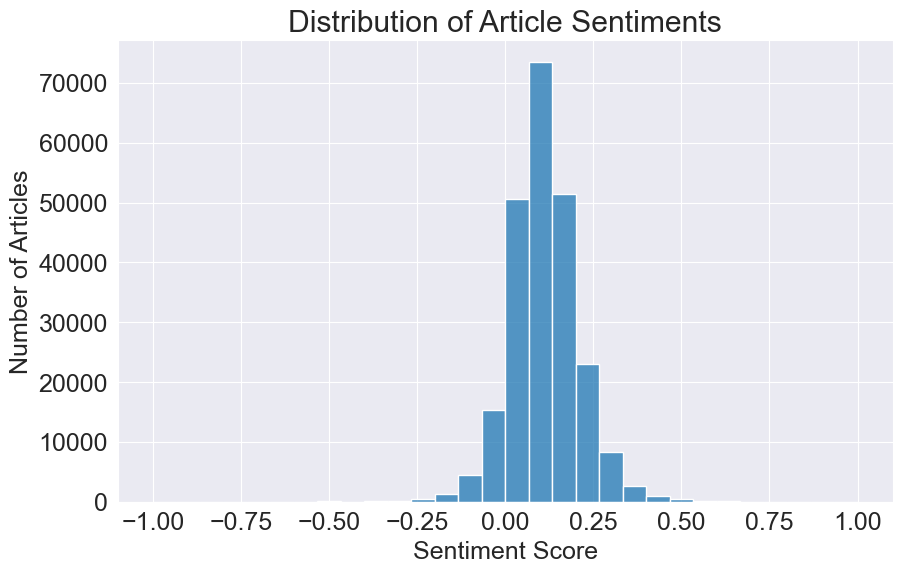

In [67]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['sentiment'], bins=30, kde=False)
plt.title('Distribution of Article Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Articles')
plt.show()

We see that the sentiments after preprocessing follow the same trend as the one before preprocessing

## Model Development

In [97]:
train_df_processed_sample = train_df_processed.iloc[:100000]
# Vectorize the training data sample
texts_sample = train_df_processed_sample['clean_article']
tfidf_matrix_sample = preprocessor.vectorize_text(texts_sample)

In [70]:
import mlflow
from mlflow import sklearn as mlflow_sklearn

In [88]:
X_tfidf = tfidf_matrix_sample # Training Feature matrix

In [89]:
mlflow.set_experiment("News Articles Clustering")

2024/03/11 01:04:00 INFO mlflow.tracking.fluent: Experiment with name 'News Articles Clustering' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///Users/mohsinkhan/Desktop/coding-challenge-ml/mlruns/828381811506102441', creation_time=1710079440770, experiment_id='828381811506102441', last_update_time=1710079440770, lifecycle_stage='active', name='News Articles Clustering', tags={}>

In [99]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

k = 5

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_tfidf)

silhouette_avg = silhouette_score(X_tfidf, kmeans_clusters)
print(f"Silhouette Score: {silhouette_avg}")

with mlflow.start_run():
    mlflow.log_param("n_clusters", k)
    mlflow.log_metric("silhouette_score", silhouette_avg)
    mlflow.sklearn.log_model(kmeans, "KMeans_Model")

Silhouette Score: 0.0009855562957992255


## Model Evaluation

In [100]:
test_df = test_data

In [103]:
# Preprocess the testing data
test_df_processed = preprocessor.preprocess(test_df, text_column='article')

# Vectorize the testing data
texts_test = test_df_processed['clean_article']
tfidf_matrix_test = preprocessor.vectorize_text(texts_test)

Pandas Apply: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58221/58221 [00:34<00:00, 1700.76it/s]


In [104]:
X_test_tfidf = tfidf_matrix_test

In [105]:
test_cluster_labels = kmeans.predict(X_test_tfidf)

In [106]:
silhouette_avg_test = silhouette_score(X_test_tfidf, test_cluster_labels)
print(f"Silhouette Score for test data: {silhouette_avg_test}")

Silhouette Score for test data: 0.0009669768565840028
